In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Set local paths
images_path = "./images"
res_path = "./data/losses"

# Dataset

## Loading and preprocessing

In [11]:
#%%Loading the dataset 

min_len = 12
dataset = Bible('./data/bible.txt', min_len = min_len)

    
len(dataset)

26691

In [12]:
# Check if every sentence begins with two ":"
i, j = 0, 0
for sentence in dataset:
    if sentence[0] == ':' and  sentence[1] == ':':
        i += 1
    elif sentence[0] == ':' and  sentence[1] != ':':
        j += 1

In [13]:
i

0

In [14]:
j

0

Mean sentence length: 28.123037728073133
Max sentence length: 102
Min sentence length: 12


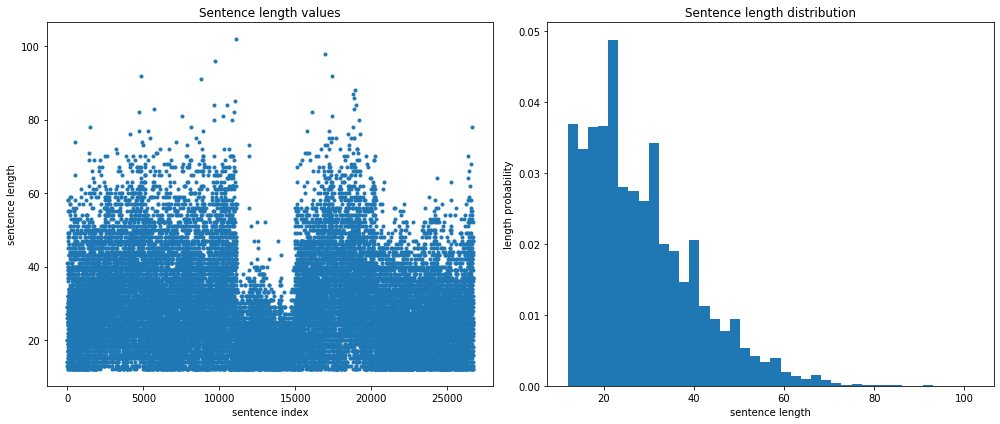

In [15]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/bible_{min_len}.png')
plt.show()

In [16]:
print(len(set(dataset.words)))

11421


## Word embeddings

In [18]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [19]:
# Load embeddings
with open('./data/embeddings_bible', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [21]:
crop_len = 10

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToIndex(words),
    ToTensor()
])

In [22]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([10])

# RNN

In [46]:
##Parameters

params = {
        # network
        'hidden_units' : 2**6, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.4,

        # training
        'batch_size' : 2000,
        'num_epochs' : 180,

        # optimizer
        'lr' : 1e-2,
        'wd' : 1e-3,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = f'LSTM_{crop_len}_{min_len}_bible'+'_{}_{}'.format(params['lr'],params['wd'])

In [24]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [25]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
loss_fn = nn.MSELoss()
# loss_fn = nn.NLLLoss()

net.to(device)

Network(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=64, out_features=50, bias=True)
  (embed): Embedding(11540, 50)
)

In [26]:
%%time

#%% Train network

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(params['num_epochs']):
    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    with torch.no_grad():
        for batch_sample in test_dataloader:
            batch = batch_sample.long().to(device)
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params }

# Save losses dictionary
with open(res_path + "/" + out_dir, 'wb') as f:
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)
    
# Save model 
torch.save(net.state_dict(), res_path + "/state_" + out_dir + '_bible.pth')



 EPOCH 1/1000
	 Training loss (epoch - mean):  0.26828902730574977
	 Validation loss (epoch - mean): 0.1797037279800714


 EPOCH 2/1000
	 Training loss (epoch - mean):  0.14963980477589828
	 Validation loss (epoch - mean): 0.13016931479674637


 EPOCH 3/1000
	 Training loss (epoch - mean):  0.11468116824443524
	 Validation loss (epoch - mean): 0.09920457355976775


 EPOCH 4/1000
	 Training loss (epoch - mean):  0.0883422648677459
	 Validation loss (epoch - mean): 0.07642255809943901


 EPOCH 5/1000
	 Training loss (epoch - mean):  0.06807954638050152
	 Validation loss (epoch - mean): 0.06709416346075261


 EPOCH 6/1000
	 Training loss (epoch - mean):  0.05774003811753713
	 Validation loss (epoch - mean): 0.050746245359085604


 EPOCH 7/1000
	 Training loss (epoch - mean):  0.0482730300953755
	 Validation loss (epoch - mean): 0.04375777364093999


 EPOCH 8/1000
	 Training loss (epoch - mean):  0.04000471933529927
	 Validation loss (epoch - mean): 0.03688900015621703


 EPOCH 9/1000
	 

	 Training loss (epoch - mean):  1.5150626705480345e-05
	 Validation loss (epoch - mean): 1.3004466287444958e-05


 EPOCH 67/1000
	 Training loss (epoch - mean):  1.2115700183830295e-05
	 Validation loss (epoch - mean): 1.0782872928952353e-05


 EPOCH 68/1000
	 Training loss (epoch - mean):  9.931217531490032e-06
	 Validation loss (epoch - mean): 8.670583036793602e-06


 EPOCH 69/1000
	 Training loss (epoch - mean):  8.38196792056596e-06
	 Validation loss (epoch - mean): 7.4653271531311885e-06


 EPOCH 70/1000
	 Training loss (epoch - mean):  6.5700657894642345e-06
	 Validation loss (epoch - mean): 5.886110723625671e-06


 EPOCH 71/1000
	 Training loss (epoch - mean):  5.4458956023714e-06
	 Validation loss (epoch - mean): 4.957950260348189e-06


 EPOCH 72/1000
	 Training loss (epoch - mean):  4.389042260299902e-06
	 Validation loss (epoch - mean): 4.1026013899681106e-06


 EPOCH 73/1000
	 Training loss (epoch - mean):  3.611434959356512e-06
	 Validation loss (epoch - mean): 3.204839600

	 Training loss (epoch - mean):  7.218616726461308e-11
	 Validation loss (epoch - mean): 6.137174065684368e-11


 EPOCH 131/1000
	 Training loss (epoch - mean):  7.256568776536392e-11
	 Validation loss (epoch - mean): 6.657242435442302e-11


 EPOCH 132/1000
	 Training loss (epoch - mean):  5.26860531171411e-11
	 Validation loss (epoch - mean): 6.418389571357356e-11


 EPOCH 133/1000
	 Training loss (epoch - mean):  8.184191497875472e-11
	 Validation loss (epoch - mean): 2.682522487832327e-11


 EPOCH 134/1000
	 Training loss (epoch - mean):  8.656502357877567e-11
	 Validation loss (epoch - mean): 5.759761219365999e-11


 EPOCH 135/1000
	 Training loss (epoch - mean):  7.437531793699984e-11
	 Validation loss (epoch - mean): 5.146126106829297e-11


 EPOCH 136/1000
	 Training loss (epoch - mean):  8.872651124764729e-11
	 Validation loss (epoch - mean): 1.2563076070094304e-10


 EPOCH 137/1000
	 Training loss (epoch - mean):  2.5563603397577445e-10
	 Validation loss (epoch - mean): 7.85986

	 Validation loss (epoch - mean): 1.9896019189052284e-10


 EPOCH 194/1000
	 Training loss (epoch - mean):  2.2225857759474207e-10
	 Validation loss (epoch - mean): 1.4923206373646063e-10


 EPOCH 195/1000
	 Training loss (epoch - mean):  2.4799456505447254e-10
	 Validation loss (epoch - mean): 7.001245662336694e-10


 EPOCH 196/1000
	 Training loss (epoch - mean):  4.5393839114965956e-10
	 Validation loss (epoch - mean): 5.33350932371325e-10


 EPOCH 197/1000
	 Training loss (epoch - mean):  2.9277756821497125e-10
	 Validation loss (epoch - mean): 3.9927164257816467e-10


 EPOCH 198/1000
	 Training loss (epoch - mean):  1.9336580947548754e-10
	 Validation loss (epoch - mean): 1.1916720671288117e-10


 EPOCH 199/1000
	 Training loss (epoch - mean):  2.091584112103776e-10
	 Validation loss (epoch - mean): 2.127401345584539e-10


 EPOCH 200/1000
	 Training loss (epoch - mean):  3.077622857416119e-10
	 Validation loss (epoch - mean): 4.6310883571182733e-10


 EPOCH 201/1000
	 Training los

	 Training loss (epoch - mean):  8.205258652014782e-10
	 Validation loss (epoch - mean): 8.869404469723944e-10


 EPOCH 258/1000
	 Training loss (epoch - mean):  9.454944391520734e-10
	 Validation loss (epoch - mean): 2.7395990107785427e-09


 EPOCH 259/1000
	 Training loss (epoch - mean):  1.0874963472475339e-09
	 Validation loss (epoch - mean): 4.800199855041593e-10


 EPOCH 260/1000
	 Training loss (epoch - mean):  7.221726400646461e-10
	 Validation loss (epoch - mean): 4.742847750912322e-10


 EPOCH 261/1000
	 Training loss (epoch - mean):  5.449251306598714e-10
	 Validation loss (epoch - mean): 1.2186675002634501e-09


 EPOCH 262/1000
	 Training loss (epoch - mean):  7.687965371154621e-10
	 Validation loss (epoch - mean): 6.113078247053926e-10


 EPOCH 263/1000
	 Training loss (epoch - mean):  5.958307505235303e-10
	 Validation loss (epoch - mean): 6.642916858196466e-10


 EPOCH 264/1000
	 Training loss (epoch - mean):  5.769188182735974e-10
	 Validation loss (epoch - mean): 8.847

	 Validation loss (epoch - mean): 1.5998727377427912e-09


 EPOCH 321/1000
	 Training loss (epoch - mean):  1.7519229229716433e-09
	 Validation loss (epoch - mean): 1.877565624090297e-09


 EPOCH 322/1000
	 Training loss (epoch - mean):  1.5320003470948178e-09
	 Validation loss (epoch - mean): 1.8259850916197665e-09


 EPOCH 323/1000
	 Training loss (epoch - mean):  1.6003742263028296e-09
	 Validation loss (epoch - mean): 3.0388401160725224e-09


 EPOCH 324/1000
	 Training loss (epoch - mean):  2.1555949877635974e-09
	 Validation loss (epoch - mean): 2.022305390542517e-09


 EPOCH 325/1000
	 Training loss (epoch - mean):  1.647477664973734e-09
	 Validation loss (epoch - mean): 1.569828539318905e-09


 EPOCH 326/1000
	 Training loss (epoch - mean):  1.2626540667727026e-09
	 Validation loss (epoch - mean): 2.2766800815833184e-09


 EPOCH 327/1000
	 Training loss (epoch - mean):  1.4174298914080798e-09
	 Validation loss (epoch - mean): 1.2741351604144353e-09


 EPOCH 328/1000
	 Training l

	 Validation loss (epoch - mean): 4.405810758841902e-09


 EPOCH 384/1000
	 Training loss (epoch - mean):  3.756193646718377e-09
	 Validation loss (epoch - mean): 4.564813086574485e-09


 EPOCH 385/1000
	 Training loss (epoch - mean):  3.505802417600115e-09
	 Validation loss (epoch - mean): 3.983691595725176e-09


 EPOCH 386/1000
	 Training loss (epoch - mean):  3.0342040119740306e-09
	 Validation loss (epoch - mean): 3.784916476927096e-09


 EPOCH 387/1000
	 Training loss (epoch - mean):  3.3566898833142362e-09
	 Validation loss (epoch - mean): 3.4493451184716267e-09


 EPOCH 388/1000
	 Training loss (epoch - mean):  3.010881561165818e-09
	 Validation loss (epoch - mean): 9.639992004611305e-09


 EPOCH 389/1000
	 Training loss (epoch - mean):  4.8249544872301335e-09
	 Validation loss (epoch - mean): 4.968547940790421e-09


 EPOCH 390/1000
	 Training loss (epoch - mean):  3.224644517219898e-09
	 Validation loss (epoch - mean): 5.950672398793546e-09


 EPOCH 391/1000
	 Training loss (ep

	 Training loss (epoch - mean):  6.171863225618451e-09
	 Validation loss (epoch - mean): 1.459370752953399e-08


 EPOCH 448/1000
	 Training loss (epoch - mean):  9.757183676402274e-09
	 Validation loss (epoch - mean): 1.6596290474390392e-08


 EPOCH 449/1000
	 Training loss (epoch - mean):  1.1472851933437877e-08
	 Validation loss (epoch - mean): 6.070664302894758e-08


 EPOCH 450/1000
	 Training loss (epoch - mean):  3.828528618918461e-08
	 Validation loss (epoch - mean): 3.4700209524735154e-08


 EPOCH 451/1000
	 Training loss (epoch - mean):  2.7823998558154436e-08
	 Validation loss (epoch - mean): 3.0187050875730914e-08


 EPOCH 452/1000
	 Training loss (epoch - mean):  2.3488442848837657e-08
	 Validation loss (epoch - mean): 3.934493116858483e-08


 EPOCH 453/1000
	 Training loss (epoch - mean):  3.137972698779707e-08
	 Validation loss (epoch - mean): 2.127015567426737e-08


 EPOCH 454/1000
	 Training loss (epoch - mean):  1.354711918712435e-08
	 Validation loss (epoch - mean): 2.

	 Training loss (epoch - mean):  1.8202913911234365e-08
	 Validation loss (epoch - mean): 5.103895353337218e-08


 EPOCH 511/1000
	 Training loss (epoch - mean):  5.434397574679049e-08
	 Validation loss (epoch - mean): 9.890562473666258e-08


 EPOCH 512/1000
	 Training loss (epoch - mean):  3.720152486918183e-08
	 Validation loss (epoch - mean): 4.531819138104638e-08


 EPOCH 513/1000
	 Training loss (epoch - mean):  3.294783789387933e-08
	 Validation loss (epoch - mean): 3.530833743145291e-08


 EPOCH 514/1000
	 Training loss (epoch - mean):  2.2909516403593408e-08
	 Validation loss (epoch - mean): 4.226753262933105e-08


 EPOCH 515/1000
	 Training loss (epoch - mean):  2.820566310427571e-08
	 Validation loss (epoch - mean): 3.619540913308877e-08


 EPOCH 516/1000
	 Training loss (epoch - mean):  2.2192334807431717e-08
	 Validation loss (epoch - mean): 4.12904201400805e-08


 EPOCH 517/1000
	 Training loss (epoch - mean):  2.5314603609908424e-08
	 Validation loss (epoch - mean): 7.638

	 Validation loss (epoch - mean): 1.174720063645654e-07


 EPOCH 574/1000
	 Training loss (epoch - mean):  1.0580517822561957e-07
	 Validation loss (epoch - mean): 1.32676925997239e-07


 EPOCH 575/1000
	 Training loss (epoch - mean):  7.22838262408214e-08
	 Validation loss (epoch - mean): 5.419309851162787e-08


 EPOCH 576/1000
	 Training loss (epoch - mean):  4.0432417619102196e-08
	 Validation loss (epoch - mean): 1.0010445286389414e-07


 EPOCH 577/1000
	 Training loss (epoch - mean):  5.954726325705031e-08
	 Validation loss (epoch - mean): 8.260872470420932e-08


 EPOCH 578/1000
	 Training loss (epoch - mean):  6.628299222309299e-08
	 Validation loss (epoch - mean): 5.80244531200827e-08


 EPOCH 579/1000
	 Training loss (epoch - mean):  3.836798284212888e-08
	 Validation loss (epoch - mean): 6.801560054656324e-08


 EPOCH 580/1000
	 Training loss (epoch - mean):  6.004000004858986e-08
	 Validation loss (epoch - mean): 4.382479557188263e-08


 EPOCH 581/1000
	 Training loss (epoch 

	 Training loss (epoch - mean):  1.540265378489144e-07
	 Validation loss (epoch - mean): 2.7476220033292185e-07


 EPOCH 638/1000
	 Training loss (epoch - mean):  2.0869231484801696e-07
	 Validation loss (epoch - mean): 3.43691058572592e-07


 EPOCH 639/1000
	 Training loss (epoch - mean):  2.394803442047515e-07
	 Validation loss (epoch - mean): 2.7103730101798794e-07


 EPOCH 640/1000
	 Training loss (epoch - mean):  2.0701973277517447e-07
	 Validation loss (epoch - mean): 1.6135135974445086e-07


 EPOCH 641/1000
	 Training loss (epoch - mean):  1.016293182942718e-07
	 Validation loss (epoch - mean): 8.226420205226349e-08


 EPOCH 642/1000
	 Training loss (epoch - mean):  9.151741627769857e-08
	 Validation loss (epoch - mean): 9.538552832431197e-08


 EPOCH 643/1000
	 Training loss (epoch - mean):  9.26111672819948e-08
	 Validation loss (epoch - mean): 2.523762098525078e-07


 EPOCH 644/1000
	 Training loss (epoch - mean):  1.5370270362452104e-07
	 Validation loss (epoch - mean): 2.20

	 Validation loss (epoch - mean): 2.672057720708247e-07


 EPOCH 701/1000
	 Training loss (epoch - mean):  1.1621948887024631e-07
	 Validation loss (epoch - mean): 1.3594968577425709e-07


 EPOCH 702/1000
	 Training loss (epoch - mean):  1.1118743314087763e-07
	 Validation loss (epoch - mean): 2.026744720379993e-07


 EPOCH 703/1000
	 Training loss (epoch - mean):  1.979647368426203e-07
	 Validation loss (epoch - mean): 6.422688978065574e-07


 EPOCH 704/1000
	 Training loss (epoch - mean):  3.3365626214058114e-07
	 Validation loss (epoch - mean): 5.468256480326279e-07


 EPOCH 705/1000
	 Training loss (epoch - mean):  5.58060349931111e-07
	 Validation loss (epoch - mean): 4.279047737110174e-07


 EPOCH 706/1000
	 Training loss (epoch - mean):  2.781217859775937e-07
	 Validation loss (epoch - mean): 1.188489018272876e-07


 EPOCH 707/1000
	 Training loss (epoch - mean):  9.138067369462988e-08
	 Validation loss (epoch - mean): 1.1338976687328231e-07


 EPOCH 708/1000
	 Training loss (ep

	 Training loss (epoch - mean):  2.73387010670726e-07
	 Validation loss (epoch - mean): 3.9155763709409826e-07


 EPOCH 765/1000
	 Training loss (epoch - mean):  2.0815894157084796e-07
	 Validation loss (epoch - mean): 5.984439022927009e-07


 EPOCH 766/1000
	 Training loss (epoch - mean):  4.33368087398706e-07
	 Validation loss (epoch - mean): 3.734408152110234e-07


 EPOCH 767/1000
	 Training loss (epoch - mean):  3.327797399011755e-07
	 Validation loss (epoch - mean): 1.659499780375727e-07


 EPOCH 768/1000
	 Training loss (epoch - mean):  1.1302154617326848e-07
	 Validation loss (epoch - mean): 1.8561619361737547e-07


 EPOCH 769/1000
	 Training loss (epoch - mean):  1.1482540948839834e-07
	 Validation loss (epoch - mean): 1.4235987907594526e-07


 EPOCH 770/1000
	 Training loss (epoch - mean):  8.609352847726699e-08
	 Validation loss (epoch - mean): 1.438908615501662e-07


 EPOCH 771/1000
	 Training loss (epoch - mean):  9.385298008842605e-08
	 Validation loss (epoch - mean): 1.96

	 Validation loss (epoch - mean): 3.207478984578232e-07


 EPOCH 828/1000
	 Training loss (epoch - mean):  1.9918782958082096e-07
	 Validation loss (epoch - mean): 3.424894402128884e-07


 EPOCH 829/1000
	 Training loss (epoch - mean):  2.4774818067149124e-07
	 Validation loss (epoch - mean): 3.615231093190589e-07


 EPOCH 830/1000
	 Training loss (epoch - mean):  3.132701176757389e-07
	 Validation loss (epoch - mean): 3.3307590389817307e-07


 EPOCH 831/1000
	 Training loss (epoch - mean):  2.4409911466486494e-07
	 Validation loss (epoch - mean): 2.850598781223781e-07


 EPOCH 832/1000
	 Training loss (epoch - mean):  1.35865293443133e-07
	 Validation loss (epoch - mean): 1.8750278670503078e-07


 EPOCH 833/1000
	 Training loss (epoch - mean):  1.4499727340167877e-07
	 Validation loss (epoch - mean): 2.402192158464707e-07


 EPOCH 834/1000
	 Training loss (epoch - mean):  1.3846448609911022e-07
	 Validation loss (epoch - mean): 1.0822165982992726e-07


 EPOCH 835/1000
	 Training loss 

	 Training loss (epoch - mean):  2.648755383916068e-07
	 Validation loss (epoch - mean): 7.736221402086911e-07


 EPOCH 892/1000
	 Training loss (epoch - mean):  4.6210452681477295e-07
	 Validation loss (epoch - mean): 8.563582776961926e-07


 EPOCH 893/1000
	 Training loss (epoch - mean):  5.292656503832824e-07
	 Validation loss (epoch - mean): 3.979155653859318e-07


 EPOCH 894/1000
	 Training loss (epoch - mean):  1.9324290489154149e-07
	 Validation loss (epoch - mean): 2.2362575421953593e-07


 EPOCH 895/1000
	 Training loss (epoch - mean):  1.0880151972532286e-07
	 Validation loss (epoch - mean): 1.516871475039419e-07


 EPOCH 896/1000
	 Training loss (epoch - mean):  1.3076929023397426e-07
	 Validation loss (epoch - mean): 3.263293864942421e-07


 EPOCH 897/1000
	 Training loss (epoch - mean):  2.8334526492611843e-07
	 Validation loss (epoch - mean): 6.301085217941348e-07


 EPOCH 898/1000
	 Training loss (epoch - mean):  2.61955649923843e-07
	 Validation loss (epoch - mean): 2.8

	 Validation loss (epoch - mean): 1.6667343729485484e-07


 EPOCH 955/1000
	 Training loss (epoch - mean):  1.7211998991884823e-07
	 Validation loss (epoch - mean): 3.551879655344483e-07


 EPOCH 956/1000
	 Training loss (epoch - mean):  2.2722518840859826e-07
	 Validation loss (epoch - mean): 4.794307697478821e-07


 EPOCH 957/1000
	 Training loss (epoch - mean):  2.390399694936954e-07
	 Validation loss (epoch - mean): 4.0511786905459404e-07


 EPOCH 958/1000
	 Training loss (epoch - mean):  3.323741894361704e-07
	 Validation loss (epoch - mean): 4.4447954415788017e-07


 EPOCH 959/1000
	 Training loss (epoch - mean):  2.1990146811171704e-07
	 Validation loss (epoch - mean): 3.1275648378240757e-07


 EPOCH 960/1000
	 Training loss (epoch - mean):  2.2430135642865096e-07
	 Validation loss (epoch - mean): 2.0124902727098926e-07


 EPOCH 961/1000
	 Training loss (epoch - mean):  1.785733041095647e-07
	 Validation loss (epoch - mean): 4.3632636932788243e-07


 EPOCH 962/1000
	 Training lo

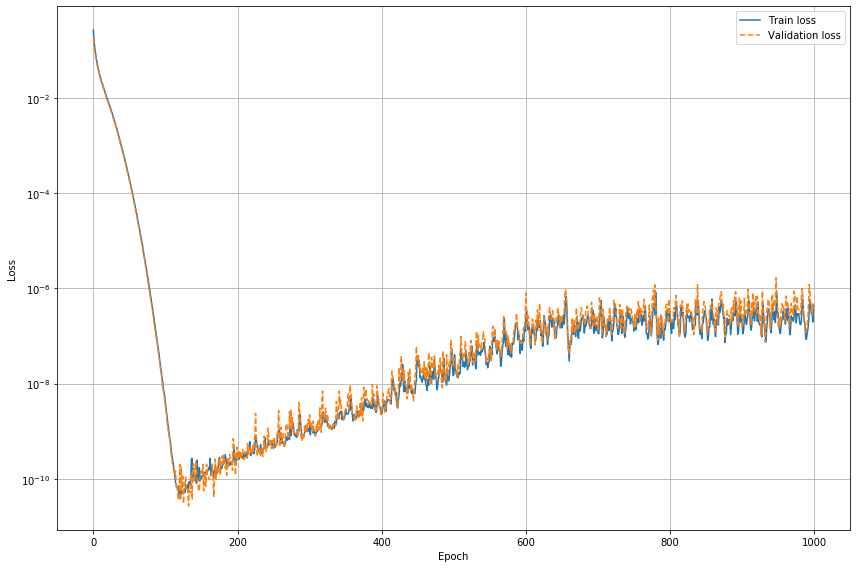

In [27]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path+f"/model_losses_{crop_len}_{min_len}"+"_{}_{}_bible.png".format(params['lr'],params['wd']))
plt.show()

# Text generation

In [60]:
# Load embeddings
with open('./data/embeddings_bible', 'rb') as f:
    embeddings = pickle.load(f)
    
# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

# Load hyperparameters
with open(res_path + "/" + out_dir, 'rb') as f:
    params = pickle.load(f)
    params = params['params']

# Embedding matrix
X = np.array(list(embeddings.values()))
    
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
state = torch.load(res_path + "/state_" + out_dir + '_bible.pth', map_location = device)

net = Network(vocab_size = len(embeddings.keys()),
              embedding_dim = 50,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

net.load_state_dict(state)
net.to(device)

(11540, 50)
torch.Size([11540, 50])


Network(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=64, out_features=50, bias=True)
  (embed): Embedding(11540, 50)
)

In [54]:
# Initialize WordToVector
w2i = WordToIndex(words)

In [55]:
# Evaluation mode
net.eval()

# print(seed, end=' ', flush=True)

# Find initial state of the RNN
with torch.no_grad():
    # Transform words in the corresponding indices
    seed_encoded = torch.tensor(w2i(seed.lower()))
    # Reshape: batch-like shape
    seed_encoded = torch.reshape(seed_encoded, (1, -1))
    # Move to the selected device
    seed_encoded.to(device)
    # Forward step
    net_out, net_state = net(seed_encoded)
    # Retrieve the index of the embedding closest to the net output
    distances = np.linalg.norm((X - net_out[:, -1, :].to('cpu').numpy()[0]), axis = 1)
    #print(distances)
    closest_index = np.argmin(distances)
    # Retrieve the chosen word text
    closest_word = words[closest_index]
    # Add to the seed sentence
    seed += ' ' + closest_word

    # Generate n words
    for i in range(15):
        # Transform words in the corresponding indices
        seed_encoded = torch.tensor(w2i(seed.lower()))
        # Reshape: batch-like shape
        seed_encoded = torch.reshape(seed_encoded, (1, -1))
        # Move to the selected device
        seed_encoded.to(device)
        # Forward step
        net_out, net_state = net(seed_encoded, net_state)
        # Retrieve the index of the embedding closest to the net output
        distances = np.linalg.norm((X - net_out[:, -1, :].to('cpu').numpy()[0]), axis = 1)
        #print(distances)
        closest_index = np.argmin(distances)
        # Retrieve the chosen word text
        closest_word = words[closest_index]
        # Add to the seed sentence
        seed += ' ' + closest_word
        # Print the current result
        # print(closest_word, end=' ', flush=True) 
print(seed)

In the name of God we say likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise
